## Natural Language Processing - Assignment 04

In [1]:
# Importing necessary modules/ libraries 
import pandas as pd 
import re
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import nltk.corpus  
from nltk.text import Text
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.naive_bayes import GaussianNB,MultinomialNB
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, roc_auc_score

import warnings
warnings.filterwarnings('ignore')

In [2]:
import multiprocessing 
num_processors = multiprocessing.cpu_count()

- Leverage the results of your homework from Week-1 and Week-2 to extract free-form text comments from inspectors
- Discard the text from “Health Code” – only keep inspectors’ comments

In [3]:
# Reading the csv file 
df = pd.read_csv('/Users/parthbansal/Downloads/Food_Inspections.csv')
df.head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude,Location
0,2572252,"Thomas, Velma ECC","Thomas, Velma ECC",26891.0,School,Risk 1 (High),3625 S Hoyne (2100W) (St. Maurice),CHICAGO,IL,60609.0,03/09/2023,Canvass,Pass,NaN,NaN,NaN,NaN
1,2571519,"DINKY DONUTS, INC","DINKY DONUTS, INC",2262653.0,Shared Kitchen User (Long Term),Risk 2 (Medium),1223 N ROSSELL,OAK PARK,IL,60302.0,02/21/2023,Canvass,Pass,NaN,NaN,NaN,NaN
2,2569647,Sauganash Elementary School,Sauganash Elementary School,25211.0,School,Risk 1 (High),6040 N Kilpatrick (4700W) AVE,CHICAGO,IL,60646.0,01/13/2023,Canvass,Pass,NaN,NaN,NaN,NaN
3,2569435,BODEGA BAY MART,BODEGA BAY MART,2868379.0,Grocery Store,Risk 2 (Medium),2007 W NORTH AVE,CHICAGO,IL,60647.0,01/10/2023,License,Pass,NaN,41.910364,-87.677919,"(41.91036370650572, -87.67791864931262)"
4,2568832,CHECKERS,CHECKERS,2808225.0,Restaurant,Risk 1 (High),107 E 95TH ST,CHICAGO,IL,60619.0,12/21/2022,Canvass,Out of Business,NaN,41.721678,-87.620237,"(41.72167844703262, -87.62023668969535)"


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252478 entries, 0 to 252477
Data columns (total 17 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Inspection ID    252478 non-null  int64  
 1   DBA Name         252478 non-null  object 
 2   AKA Name         249989 non-null  object 
 3   License #        252470 non-null  float64
 4   Facility Type    247418 non-null  object 
 5   Risk             252403 non-null  object 
 6   Address          252478 non-null  object 
 7   City             252304 non-null  object 
 8   State            252428 non-null  object 
 9   Zip              252401 non-null  float64
 10  Inspection Date  252478 non-null  object 
 11  Inspection Type  252477 non-null  object 
 12  Results          252478 non-null  object 
 13  Violations       183692 non-null  object 
 14  Latitude         251609 non-null  float64
 15  Longitude        251609 non-null  float64
 16  Location         251609 non-null  obje

In [5]:
df = df.dropna(subset = 'Violations')
df.shape

(183692, 17)

In [6]:
df = df[['Results', 'Violations']]
df.sample(5, random_state = 42)

,Results,Violations
50373,Fail,5. PROCEDURES FOR RESPONDING TO VOMITING AND D...
3580,Fail,"1. SOURCE SOUND CONDITION, NO SPOILAGE, FOODS ..."
46265,Fail,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E..."
42805,Fail,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E..."
244218,Pass,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...


In [7]:
df["Results"].value_counts()

Pass                  99163
Fail                  45694
Pass w/ Conditions    38103
No Entry                620
Not Ready                71
Out of Business          41
Name: Results, dtype: int64

In [8]:
# Only keeping rows with values Pass, Fail and Pass w/ Conditions
df = df[~df['Results'].isin(['No Entry', 'Not Ready', 'Out of Business'])]
df.shape

(182960, 2)

In [9]:
# 0 if Results == Pass or Pass w/ Conditions, 1 if Results == Fail
df['Result'] = df['Results'].apply(lambda x: 0 if x in ['Pass', 'Pass w/ Conditions'] else 1)
df.drop('Results', axis=1, inplace=True)
df.sample(5, random_state = 42)

,Violations,Result
52828,37. FOOD PROPERLY LABELED; ORIGINAL CONTAINER ...,0
74125,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",0
87000,3. POTENTIALLY HAZARDOUS FOOD MEETS TEMPERATUR...,0
173671,21. * CERTIFIED FOOD MANAGER ON SITE WHEN POTE...,0
137684,33. FOOD AND NON-FOOD CONTACT EQUIPMENT UTENSI...,0


In [10]:
df['Result'].value_counts()

0    137266
1     45694
Name: Result, dtype: int64

In [11]:
df['Comments'] = df['Violations'].apply(lambda x : re.sub(r'[0-9#\-]+\.[0-9]+\s+','',x))
df['Comments'] = df['Comments'].apply(lambda x : re.findall(r'(?<=Comments: )[^|]*(?=\||$)',x))
df['Comments'] = df['Comments'].apply(lambda x: ' '.join(str(i) for i in x))

In [12]:
df.drop('Violations', axis=1, inplace=True)
df.sample(5, random_state = 42)

,Result,Comments
52828,0,INSTRUCTED TO LABEL THE WHITE ROLLING BULK FOO...
74125,0,NOTED NO EMPLOYEE HEALTH POLICY ON SITE AT THE...
87000,0,Found the following potentially hazardous food...
173671,0,FOUND NO CITY OF CHICAGO CERTIFIED FOOD MANAGE...
137684,0,"OBSERVED THE REAR SLISER NOT CLEAN, INNSTRUCTE..."


- Build classification model, predicting the outcome of inspection – your target variable is “Results”
- Explain why you selected a particular text pre-processing technique
- Visualize results of at least two text classifiers and select the most robust one
- You can choose to build a binary classifier (limiting your data to Pass / Fail) or multinomial classifier with all available values in Results

In [13]:
# Train_test_split
X = df['Comments']
y = df['Result']
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3, random_state=42)

In [14]:
# Applying text preprocessing techniques
cv = CountVectorizer(stop_words='english', ngram_range=(1,3))
%time X_train_cv = cv.fit_transform(X_train)

CPU times: user 26.6 s, sys: 628 ms, total: 27.3 s
Wall time: 27.3 s


In [15]:
tfidf = TfidfVectorizer(stop_words="english",ngram_range=(1,3))
%time X_train_tfidf = tfidf.fit_transform(X_train)

CPU times: user 28.8 s, sys: 767 ms, total: 29.6 s
Wall time: 29.6 s


In [16]:
X_test_cv = cv.transform(X_test)
X_test_tfidf = tfidf.transform(X_test)

#### I decided to use the TFIDF Vectorizer because it has two key advantages. Firstly, it is generally faster to use in the model training process. Secondly, it captures the context of the text and also takes into account the frequency of a particular word in the text, regardless of whether the word occurs frequently or infrequently. In other words, the TFIDF Vectorizer is able to identify both high and low frequency words.

#### Note: I did plan on making use of lemmatization. However, I was getting a runtime error and so, I decided on running the models without it. For future extensions, I might make use of it. 

In [17]:
# Building varied classification models

In [18]:
# Logistic Regression with Count Vectorizer
logreg_cv = LogisticRegression()
%time logreg_cv.fit(X_train_cv, y_train)

CPU times: user 2min 8s, sys: 36.1 s, total: 2min 44s
Wall time: 33.1 s


LogisticRegression()

In [19]:
y_pred_cv = logreg_cv.predict(X_test_cv)

In [20]:
print(classification_report(y_test, y_pred_cv))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96     41101
           1       0.92      0.86      0.89     13787

    accuracy                           0.94     54888
   macro avg       0.93      0.92      0.92     54888
weighted avg       0.94      0.94      0.94     54888



In [21]:
print(f"Test Accuracy: {metrics.accuracy_score(y_test, y_pred_cv) * 100:.1f}%")

Test Accuracy: 94.5%


In [22]:
print(metrics.confusion_matrix(y_test, y_pred_cv))

[[40012  1089]
 [ 1947 11840]]


In [23]:
y_pred_prob_cv = logreg_cv.predict_proba(X_test_cv)
roc_auc_score(y_test, y_pred_prob_cv[:,1])

0.9715054527976164

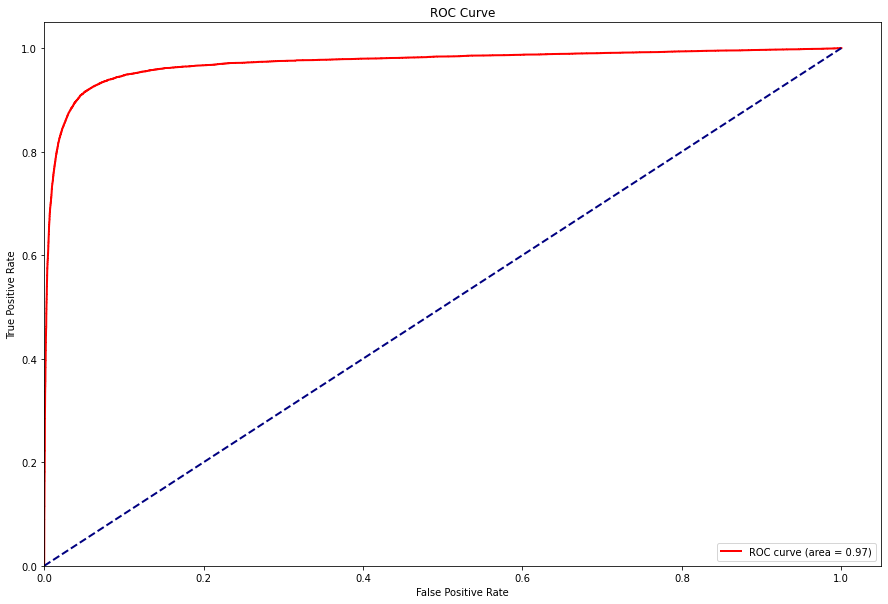

In [24]:
def roc_curve_plot(y_test_, y_pred_prob_):
    roc_score = roc_auc_score(y_test_, y_pred_prob_)
    fpr, tpr, thresholds = roc_curve(y_test_, y_pred_prob_)
    plt.figure(figsize=(15, 10))   
    lw = 2
    plt.plot(fpr, tpr, color='red',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_score)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.05])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()
    
roc_curve_plot(y_test, y_pred_prob_cv[:,1])

In [25]:
# Logistic Regression with Tfidf Vectorizer
logreg_tfidf = LogisticRegression()
%time logreg_tfidf.fit(X_train_tfidf, y_train)
y_pred_tfidf = logreg_tfidf.predict(X_test_tfidf)

CPU times: user 1min 57s, sys: 32.8 s, total: 2min 29s
Wall time: 30.2 s


In [26]:
print(classification_report(y_test, y_pred_tfidf))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96     41101
           1       0.91      0.85      0.88     13787

    accuracy                           0.94     54888
   macro avg       0.93      0.91      0.92     54888
weighted avg       0.94      0.94      0.94     54888



In [27]:
print(f"Test Accuracy: {metrics.accuracy_score(y_test, y_pred_tfidf) * 100:.1f}%")
print(f"Test Precision: {metrics.precision_score(y_test, y_pred_tfidf) * 100:.1f}%")
print(f"Test Recall: {metrics.recall_score(y_test, y_pred_tfidf) * 100:.1f}%")

Test Accuracy: 94.0%
Test Precision: 90.5%
Test Recall: 85.0%


In [28]:
print(metrics.confusion_matrix(y_test, y_pred_tfidf))

[[39877  1224]
 [ 2066 11721]]


In [29]:
y_pred_prob_tfidf = logreg_cv.predict_proba(X_test_tfidf)
roc_auc_score(y_test, y_pred_prob_tfidf[:,1])

0.911975719732369

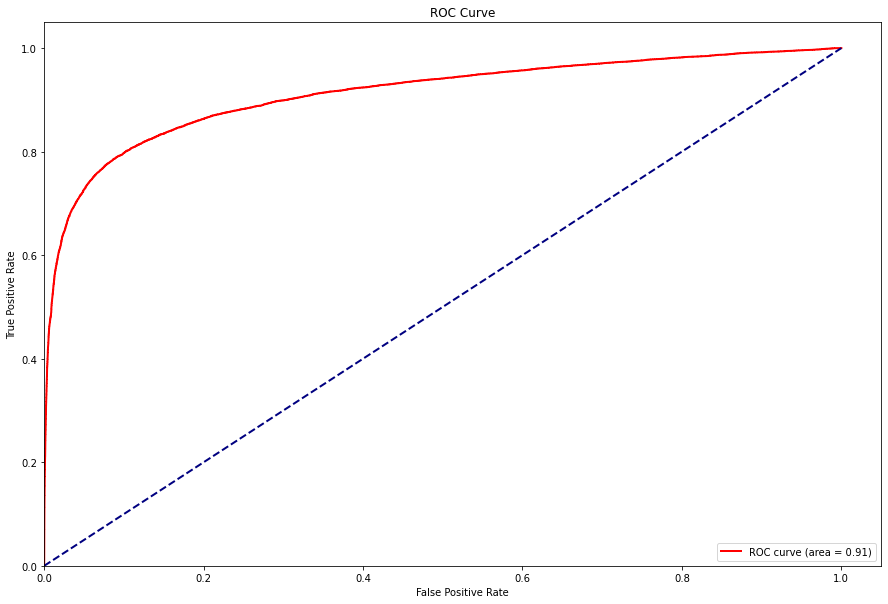

In [30]:
roc_curve_plot(y_test, y_pred_prob_tfidf[:,1])

In [31]:
# Support Vector Machine with Count Vectorizer
sv= svm.LinearSVC()
%time sv.fit(X_train_cv,y_train)
y_pred_cv_svm = sv.predict(X_test_cv)

CPU times: user 1min, sys: 607 ms, total: 1min 1s
Wall time: 1min 1s


In [32]:
print(classification_report(y_test, y_pred_cv_svm))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96     41101
           1       0.90      0.86      0.88     13787

    accuracy                           0.94     54888
   macro avg       0.93      0.91      0.92     54888
weighted avg       0.94      0.94      0.94     54888



In [33]:
print(f"Test Accuracy: {metrics.accuracy_score(y_test, y_pred_cv_svm) * 100:.1f}%")

Test Accuracy: 94.2%


In [34]:
print(metrics.confusion_matrix(y_test, y_pred_cv_svm))

[[39839  1262]
 [ 1931 11856]]


In [35]:
metrics.roc_auc_score(y_test,y_pred_cv_svm)

0.9146178373256458

In [36]:
# Support Vector Machine with Tfidf Vectorizer 
%time sv.fit(X_train_tfidf, y_train)
y_pred_tfidf_svm = sv.predict(X_test_tfidf)

CPU times: user 3.61 s, sys: 106 ms, total: 3.72 s
Wall time: 3.72 s


In [37]:
print(classification_report(y_test, y_pred_tfidf_svm))

              precision    recall  f1-score   support

           0       0.96      0.97      0.97     41101
           1       0.91      0.89      0.90     13787

    accuracy                           0.95     54888
   macro avg       0.94      0.93      0.94     54888
weighted avg       0.95      0.95      0.95     54888



In [38]:
print(f"Test Accuracy: {metrics.accuracy_score(y_test, y_pred_tfidf_svm) * 100:.1f}%")
print(f"Test Precision: {metrics.precision_score(y_test, y_pred_tfidf_svm) * 100:.1f}%")
print(f"Test Recall: {metrics.recall_score(y_test, y_pred_tfidf_svm) * 100:.1f}%")

Test Accuracy: 95.2%
Test Precision: 91.3%
Test Recall: 89.3%


In [39]:
print(metrics.confusion_matrix(y_test, y_pred_tfidf_svm))

[[39927  1174]
 [ 1476 12311]]


In [40]:
metrics.roc_auc_score(y_test,y_pred_tfidf_svm)

0.9321894226046902

In [41]:
# Naive Baye with Count Vectorizer 
nb = MultinomialNB()
%time nb.fit(X_train_cv,y_train)
y_pred_cv_nb= nb.predict(X_test_cv)

CPU times: user 289 ms, sys: 51.7 ms, total: 340 ms
Wall time: 339 ms


In [42]:
print(classification_report(y_test,y_pred_cv_nb))

              precision    recall  f1-score   support

           0       0.94      0.90      0.92     41101
           1       0.74      0.82      0.78     13787

    accuracy                           0.88     54888
   macro avg       0.84      0.86      0.85     54888
weighted avg       0.89      0.88      0.88     54888



In [43]:
print(f"Test Accuracy: {metrics.accuracy_score(y_test, y_pred_cv_nb) * 100:.1f}%")

Test Accuracy: 88.2%


In [44]:
print(metrics.confusion_matrix(y_test, y_pred_cv_nb))

[[37081  4020]
 [ 2431 11356]]


In [45]:
y_pred_cv_nb_prob= nb.predict_proba(X_test_cv)
roc_auc_score(y_test, y_pred_cv_nb_prob[:,1])

0.8922401920361743

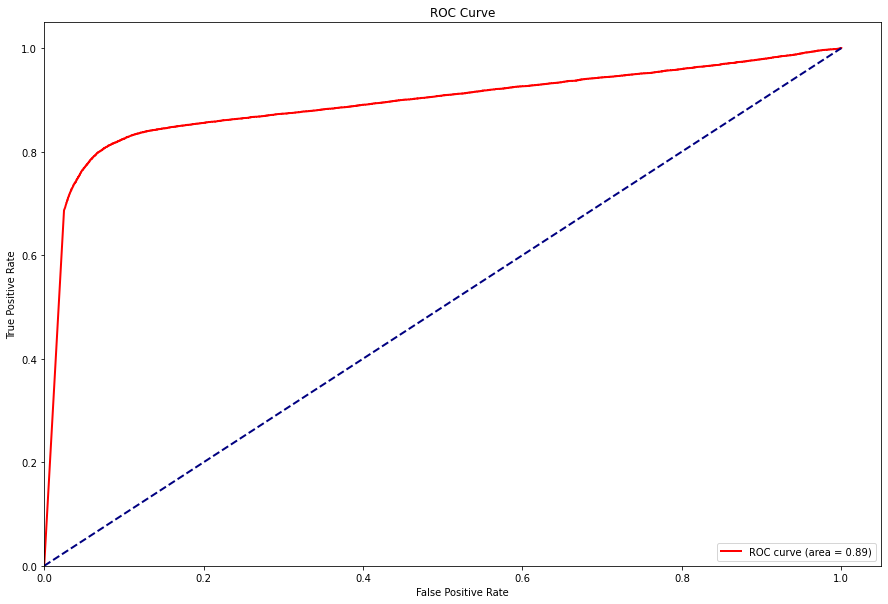

In [46]:
roc_curve_plot(y_test, y_pred_cv_nb_prob[:,1])

In [47]:
# Naive Bayes on Tfidf Vectorizer
%time nb.fit(X_train_tfidf,y_train)
y_pred_tfidf_nb= nb.predict(X_test_tfidf)

CPU times: user 183 ms, sys: 8.81 ms, total: 192 ms
Wall time: 191 ms


In [48]:
print(classification_report(y_test,y_pred_tfidf_nb))

              precision    recall  f1-score   support

           0       0.80      1.00      0.89     41101
           1       0.95      0.25      0.40     13787

    accuracy                           0.81     54888
   macro avg       0.88      0.62      0.64     54888
weighted avg       0.84      0.81      0.76     54888



In [49]:
print(f"Test Accuracy: {metrics.accuracy_score(y_test, y_pred_tfidf_nb) * 100:.1f}%")
print(f"Test Precision: {metrics.precision_score(y_test, y_pred_tfidf_nb) * 100:.1f}%")
print(f"Test Recall: {metrics.recall_score(y_test, y_pred_tfidf_nb) * 100:.1f}%")

Test Accuracy: 80.9%
Test Precision: 95.1%
Test Recall: 25.3%


In [50]:
print(metrics.confusion_matrix(y_test, y_pred_tfidf_nb))

[[40922   179]
 [10295  3492]]


In [51]:
y_pred_tfidf_nb_prob= nb.predict_proba(X_test_cv)
roc_auc_score(y_test, y_pred_tfidf_nb_prob[:,1])

0.5833521931311105

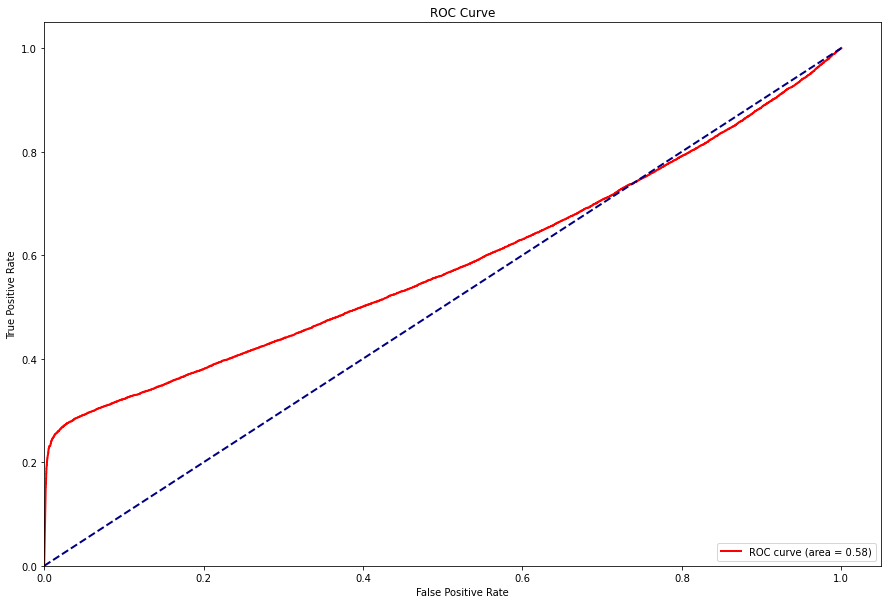

In [52]:
roc_curve_plot(y_test, y_pred_tfidf_nb_prob[:,1])

#### After comparing the performance of the three classifiers, it can be seen that the Support Vector Machine (SVM) performs the best overall. Specifically, SVM outperforms the other two classifiers in terms of accuracy, precision, and recall for both majority and minority classes. Additionally, SVM has a good AUC_ROC_score, which is an important measure of how well the minority class has been predicted. Compared to logistic regression, SVM takes less time to execute, while Naive Bayes takes the least time but its performance is lower than SVM. Therefore, overall, SVM is the best choice among the three classifiers based on these factors.
- Test Accuracy: 95.2%
- Test Precision: 91.3%
- Test Recall: 89.3%